# Assignment 5: Hands-on: Convolutional Neural Networks for Image Segementation (20 Pts)

In this homework, we will explore segmentation and data preprocessing with convolutional neural networks.

## Conda Setup

Generate the conda environment by running in the terminal:

`conda create --name gcv_exercise_5 python=3.11`

Run to activate environment:

`conda activate gcv_exercise_5`

Install all required packages for this exercise by running:

`conda install matplotlib numpy scikit-image scikit-learn tqdm pandas`

Install PyTorch and its prerequisites:

`conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia`

Install Albumentations, pandas, seaborn and ipykernel for the preprocessing

`conda install -c conda-forge albumentations pandas ipykernel seaborn`

(Optional) If you are working on the TUWEL Juypter Notebooks:

`ipython kernel install --name "GCV_E_5" --user`

## Notebook Setup & Imports

In [1]:
pip install albumentations


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries

import math
import random
from random import randint
from tqdm import tqdm
import pandas as pd
import numpy as np
import albumentations as A # Scikit-Image and -Learn library for image augmentation
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt # useful plotting library for python
import seaborn as sns # useful plotting library for python
import torch # framework for deep learning
import torchvision
import torch.nn as nn
import torchvision.models as models

# This code is to make matplotlib figures appear inline in the notebook rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Set random seeds for reproducibility

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Define constants for masks

MASK_FG = 0
MASK_BG = 1
MASK_IGNORE = 2

## Part 1: Data preparation (9 Pts)

When it comes to deep learning, the quality and quantity of our data can make or break the performance of our model. Therefore, in this section, we'll be preparing our dataset in a format that is most suitable for use in the remainder of our framework.

For image-based tasks, two commonly used packages for data preparation and transformation are torchvision and albumentations. These packages provide a range of data loaders for common datasets and various image transformation operations that we can use to preprocess our data.

Specifically, we'll be working with the oxford-iiit-pet dataset in this section. Our aim is to apply a series of data augmentations to the images to increase the diversity and quantity of our training data, while also normalizing the images to facilitate more effective model training.

To perform these augmentations, we'll utilize the functions provided by the torchvision and albumentations packages. The input images can be found in the data/oxford-iiit-pet/images/ directory, while the corresponding masks are located in the data/oxford-iiit-pet/annotations/trimaps/ directory. Note that all images should be resized to 64x64 after the augmentation step. The dataset will be automatically downloaded by the next cell.

In [3]:
torchvision.datasets.OxfordIIITPet("data", download=True)

df = pd.read_csv(
    "data/oxford-iiit-pet/annotations/list.txt",
    delimiter=" ",
    skiprows=6,
    header=None,
    names=["stem", "class_id", "species", "breed"]
)
df["class_name"] = df.stem.map(lambda x: x.split("_")[0])
df["image"] = df.stem.map(lambda x: f"data/oxford-iiit-pet/images/{x}.jpg")
df["trimap"] = df.stem.map(lambda x: f"data/oxford-iiit-pet/annotations/trimaps/{x}.png")

df

,stem,class_id,species,breed,class_name,image,trimap
0,Abyssinian_100,1,1,1,Abyssinian,data/oxford-iiit-pet/images/Abyssinian_100.jpg,data/oxford-iiit-pet/annotations/trimaps/Abyss...
1,Abyssinian_101,1,1,1,Abyssinian,data/oxford-iiit-pet/images/Abyssinian_101.jpg,data/oxford-iiit-pet/annotations/trimaps/Abyss...
2,Abyssinian_102,1,1,1,Abyssinian,data/oxford-iiit-pet/images/Abyssinian_102.jpg,data/oxford-iiit-pet/annotations/trimaps/Abyss...
3,Abyssinian_103,1,1,1,Abyssinian,data/oxford-iiit-pet/images/Abyssinian_103.jpg,data/oxford-iiit-pet/annotations/trimaps/Abyss...
4,Abyssinian_104,1,1,1,Abyssinian,data/oxford-iiit-pet/images/Abyssinian_104.jpg,data/oxford-iiit-pet/annotations/trimaps/Abyss...
...,...,...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,yorkshire,data/oxford-iiit-pet/images/yorkshire_terrier_...,data/oxford-iiit-pet/annotations/trimaps/yorks...
7345,yorkshire_terrier_97,37,2,25,yorkshire,data/oxford-iiit-pet/images/yorkshire_terrier_...,data/oxford-iiit-pet/annotations/trimaps/yorks...
7346,yorkshire_terrier_98,37,2,25,yorkshire,data/oxford-iiit-pet/images/yorkshire_terrier_...,data/oxford-iiit-pet/annotations/trimaps/yorks...
7347,yorkshire_terrier_99,37,2,25,yorkshire,data/oxford-iiit-pet/images/yorkshire_terrier_...,data/oxford-iiit-pet/annotations/trimaps/yorks...


### Visualize dataset information (2 Pts)

Before diving into the model training phase, it's essential to gain a high-level overview of the data we're working with. This can be achieved using visualization tools such as Matplotlib and Seaborn. Seaborn, in particular, is a popular Python data visualization library that offers a user-friendly interface for creating informative and aesthetically pleasing statistical graphics.

By visualizing the data in this way, we can identify patterns and trends in the input images and labels, which can help us make informed decisions about our model design and training strategy. The resulting plot should resemble the following visualization:

<center><img src="imgs/example_data_visualization.png" alt="Plot" width="960" /></center>

<BarContainer object of 25 artists>

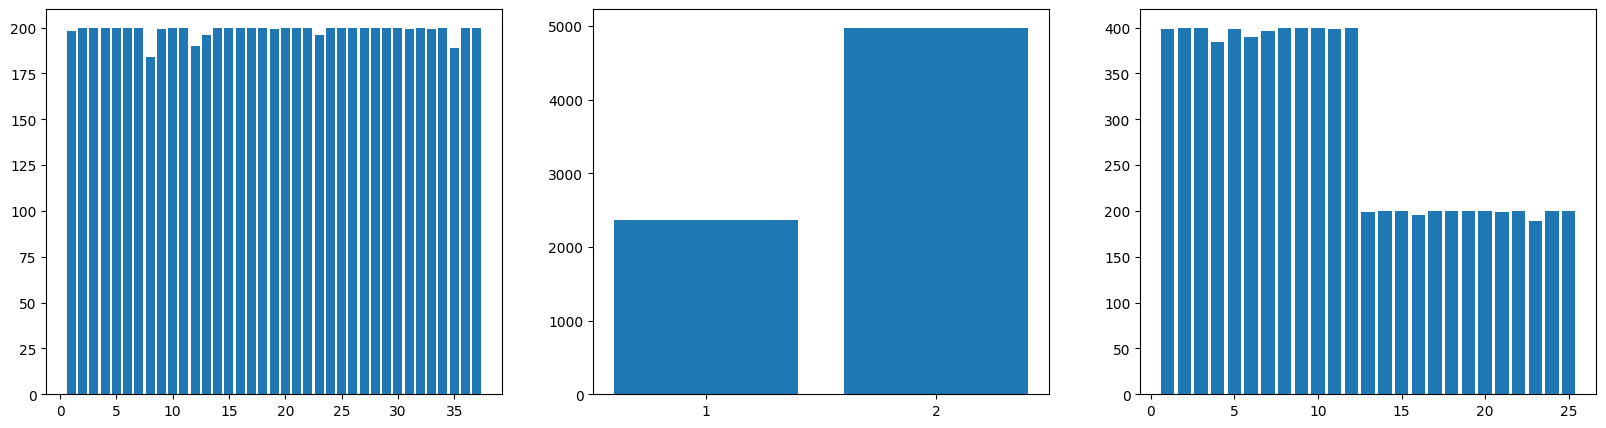

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
# *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
axs[0].bar(df['class_id'].value_counts().index, df['class_id'].value_counts().values)
axs[1].bar(df['species'].value_counts().index, df['species'].value_counts().values, tick_label=[2, 1])
axs[1].xaxis
axs[2].bar(df['breed'].value_counts().index, df['breed'].value_counts().values)
# *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

### Visualize dataset example (1 Pt)

Now, let's take a moment to visualize a sample from our training dataset. To start, we'll focus on the first image in the dataset, which should give us a good idea of what the training data looks like.

By examining the training data in more detail, we can better understand the characteristics of the input images and the corresponding labels, which can inform our model design and hyperparameter selection. So, without further ado, let's take a look at the first image in the dataset. It should resemble the following visualization:

<center><img src="imgs/example_image.png" alt="Plot" width="960" /></center>

stem                                             Abyssinian_100
class_id                                                      1
species                                                       1
breed                                                         1
class_name                                           Abyssinian
image            data/oxford-iiit-pet/images/Abyssinian_100.jpg
trimap        data/oxford-iiit-pet/annotations/trimaps/Abyss...
Name: 0, dtype: object


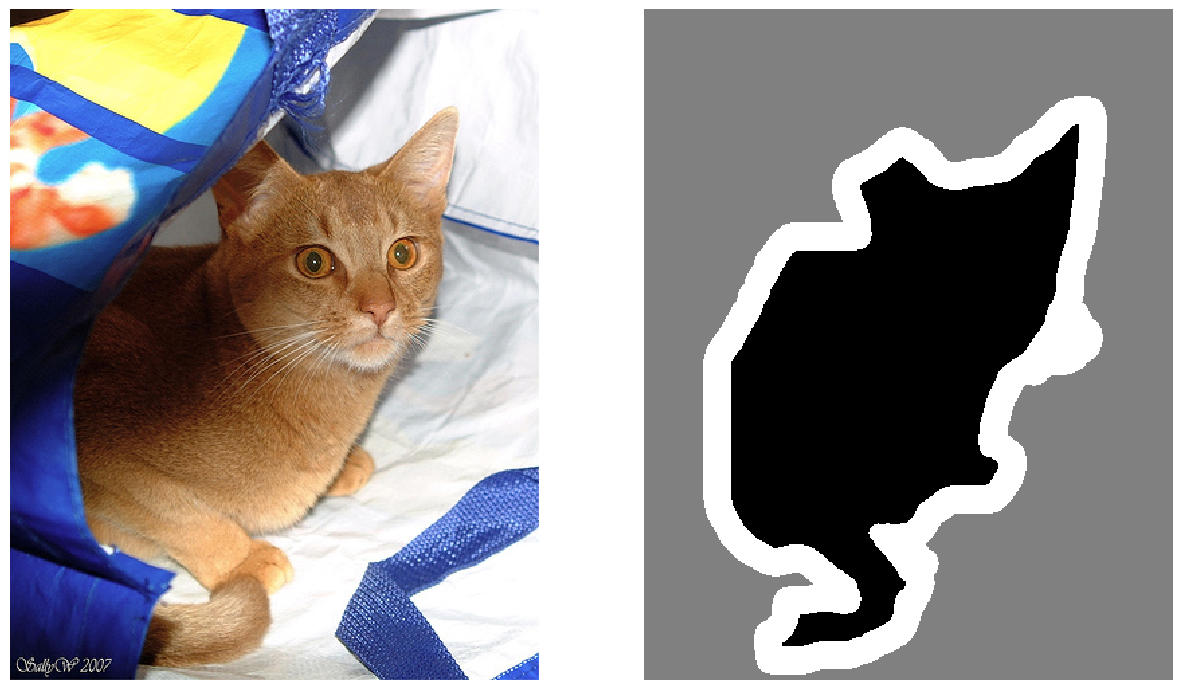

In [5]:
print(df.iloc[0])
# *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
img = Image.open(df.iloc[0]['image'])
trimap = Image.open(df.iloc[0]['trimap'])

fig, axs = plt.subplots(1, 2, figsize=(15,10))


axs[0].imshow(img)
axs[0].axis('off')

axs[1].imshow(trimap)
axs[1].axis('off')

plt.show()
# *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

### Implement the dataloader (5 Pts)

Moving forward, we'll be creating a dataloader to streamline the process of loading and augmenting our data. To do this, we'll need to implement the __getitem__ function and define the specific image augmentation techniques we'll be using. Please note, the images may not all be RGB, so you have to convert them to RGB (.convert('RGB')). 

The augmentations we'll be applying during training are:
- Flipping the image horizontally and vertically
- Randomly scaling the image
- Randomly rotating the image
- Random brightness and contrast
- Resizing the image to 64 x 64
- Normalization with the imagenet mean and std

To ensure a fair and unbiased evaluation, it is important to keep the validation set representative of the original data distribution without introducing any artificial modifications. This allows us to accurately assess the model's performance on unseen data and make reliable comparisons between different models or approaches. There for we will only apply the resizing and the normalization to the imagenet mean and std. The output of the augmented image should be a pytorch tensor.

By automating the image augmentation process, we can efficiently generate a diverse range of training samples, which in turn helps to improve the robustness and generalization of our model. So, let's get started by defining the __getitem__ function and specifying the desired data augmentation methods.

Note: The trimap has three pixel annotations: 1: Foreground, 2: Background, 3: Not classified. For training you have to adapt these, such that they start with 0. (0: Foreground, 1: Background, 2: Not classified)

Note: the `nn.CrossEntropyLoss()` loss expects the mask to be of type long.

The reference plots where created with batchsize equal to 512, if you have memory constraints feel free to lower this number. 

In [ ]:
class IIITDataset(torch.utils.data.Dataset):
    """IIIT dataset.
    Args:
        df (pandas.DataFrame): Pandas dataframe obtained from the Oxford-IIIT Pet Dataset.
        tfm (albumentations.Compose): composed albumentations transforms.

    Methods:
        _len_: returns the length of the dataset.
        _getitem_: returns a tuple of (image, mask) where mask is a 2D numpy array.
    """
    def __init__(self, df, tfm):
        """Initialize the dataset.

        Args:
            df (pandas.DataFrame): Pandas dataframe obtained from the Oxford-IIIT Pet Dataset.
            
        """
        self.df = df
        self.tfm = tfm
    def __len__(self):
        """Return the length of the dataset."""
        return len(self.df)
    def __getitem__(self, i):
        """Return a tuple of (image, mask) where mask is a 2D numpy array.
        Args:
            i (int): index of the image in the dataset.
        Returns:
            tuple: (image, mask) where mask is a 2D numpy array.
        """
        # **BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)**
        img = Image.open(self.df.iloc[i]['image']).convert('RGB')
        mask = Image.open(self.df.iloc[i]['trimap'])
        img = np.array(img)
        mask = np.array(mask) - 1
        return img, mask
        # **END OF YOUR CODE (DO NOT DELETE THIS LINE)**

class ApplyTransform(torch.utils.data.Dataset):
    """Apply transformations to a Dataset
    Wrapper to apply correct transformes (val/train) to the dataset splits.    
    Args:
        dataset (Dataset): A Dataset that returns (img, mask)
        transform (albumentations.Compose): composed albumentations transforms.

    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.tfm = transform

    def __getitem__(self, idx):
        """Return a transformed tuple of (image, mask) where mask is a 2D numpy array.
        Args:
            i (int): index of the image in the dataset.
        Returns:
            tuple: transformed (image, mask) where mask is a 2D numpy array.
        """
        img, mask = self.dataset[idx]

        # **BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)**
        if self.tfm:
            augmented = self.tfm(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.long()


        return img, mask
        # **END OF YOUR CODE (DO NOT DELETE THIS LINE)**

    def __len__(self):
        return len(self.dataset)

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

# transformations for the train and validation sets
train_tfm = A.Compose([
    # **BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)**
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomScale(),
    A.RandomRotate90(),
    A.RandomBrightnessContrast(),
    A.Resize(64, 64),
    A.Normalize(imagenet_mean, imagenet_std),
    A.ToTensorV2()
    # **END OF YOUR CODE (DO NOT DELETE THIS LINE)**
])
# Only normalize, resize and convert to tensor for validation
# to keep the validation deterministic
val_tfm = A.Compose([
    # **BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)**
    A.Normalize(imagenet_mean, imagenet_std),
    A.Resize(64, 64),
    A.ToTensorV2()
    # **END OF YOUR CODE (DO NOT DELETE THIS LINE)**
])

def imagenet_denorm(x):
    """x: array-like with shape (..., H, W, C)"""
    return x * imagenet_std + imagenet_mean

dataset = IIITDataset(df, tfm=train_tfm)

print(len(dataset))

# split dataset into train and test
train_set, validation_set = torch.utils.data.random_split(dataset, [len(dataset) - 2000, 2000])
train_set = ApplyTransform(train_set, transform=train_tfm)
validation_set = ApplyTransform(validation_set, transform=val_tfm)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=512, shuffle=False)

7349


### Visualize augmented images with masks (1 Pt)

Before proceeding further, it's important to conduct a sanity check to verify the integrity of our data. One approach we can take is to visually inspect a sample of images and their corresponding masks from the augmented dataset. This allows us to ensure that our data augmentation process is functioning correctly and not inadvertently introducing any errors or biases into the training data.

To give you an idea, here's an example of what this might look like:

<center><img src="imgs/example_aug.png" alt="Plot" width="960" /></center>

Note: Matplotlib will automatically clip the image and the mask. Normalize them between 0 and 1 before plotting them. Warning: 

`Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).`

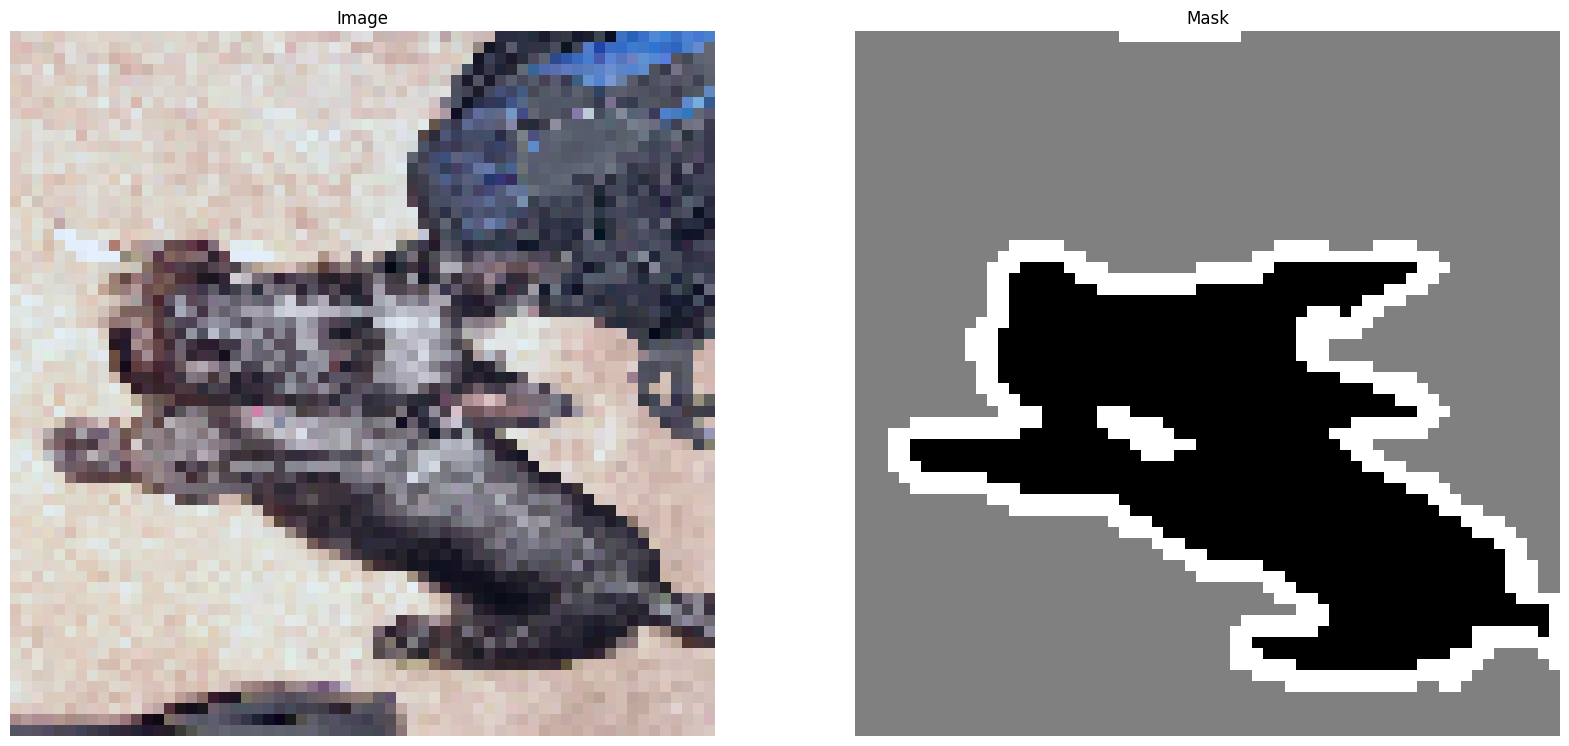

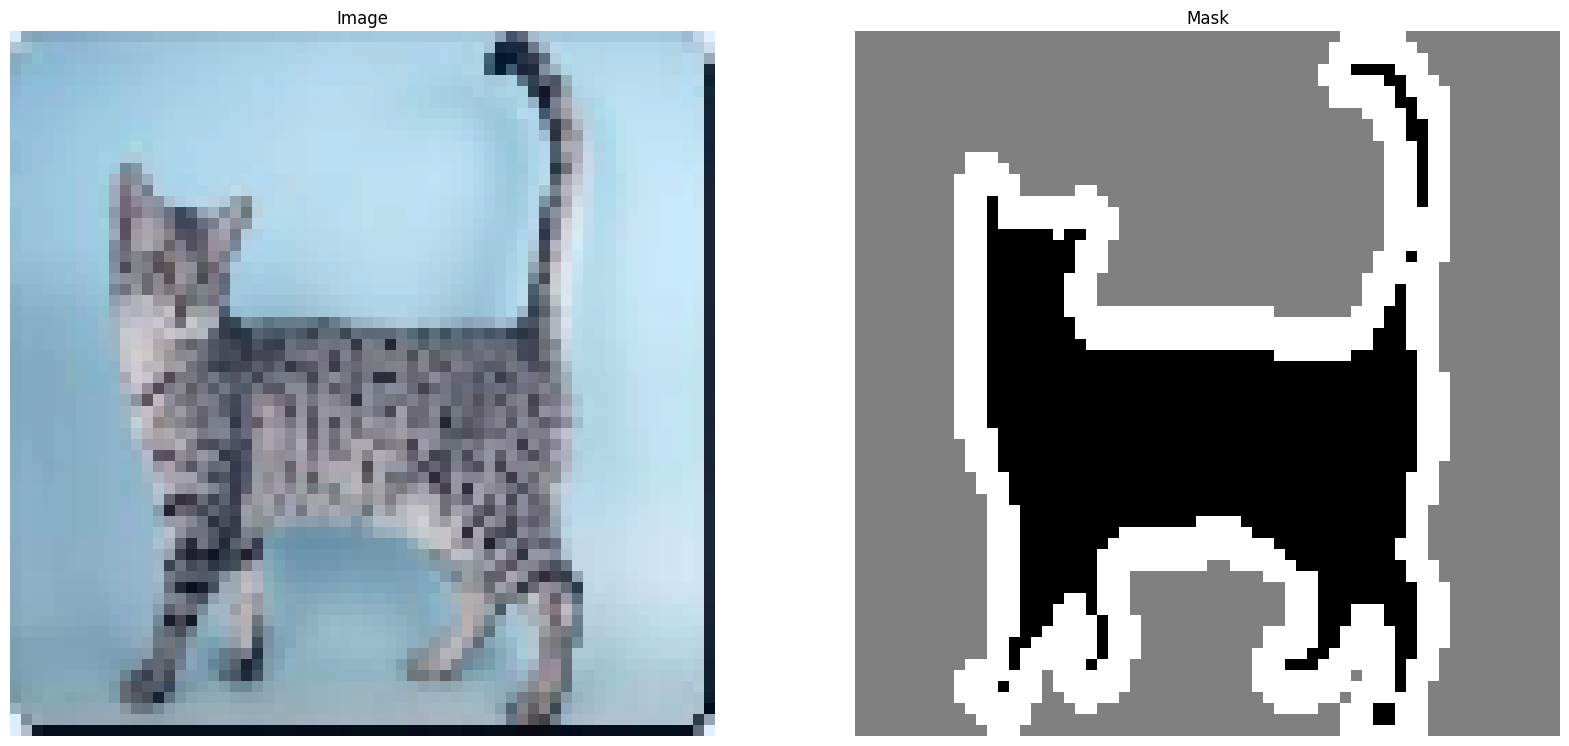

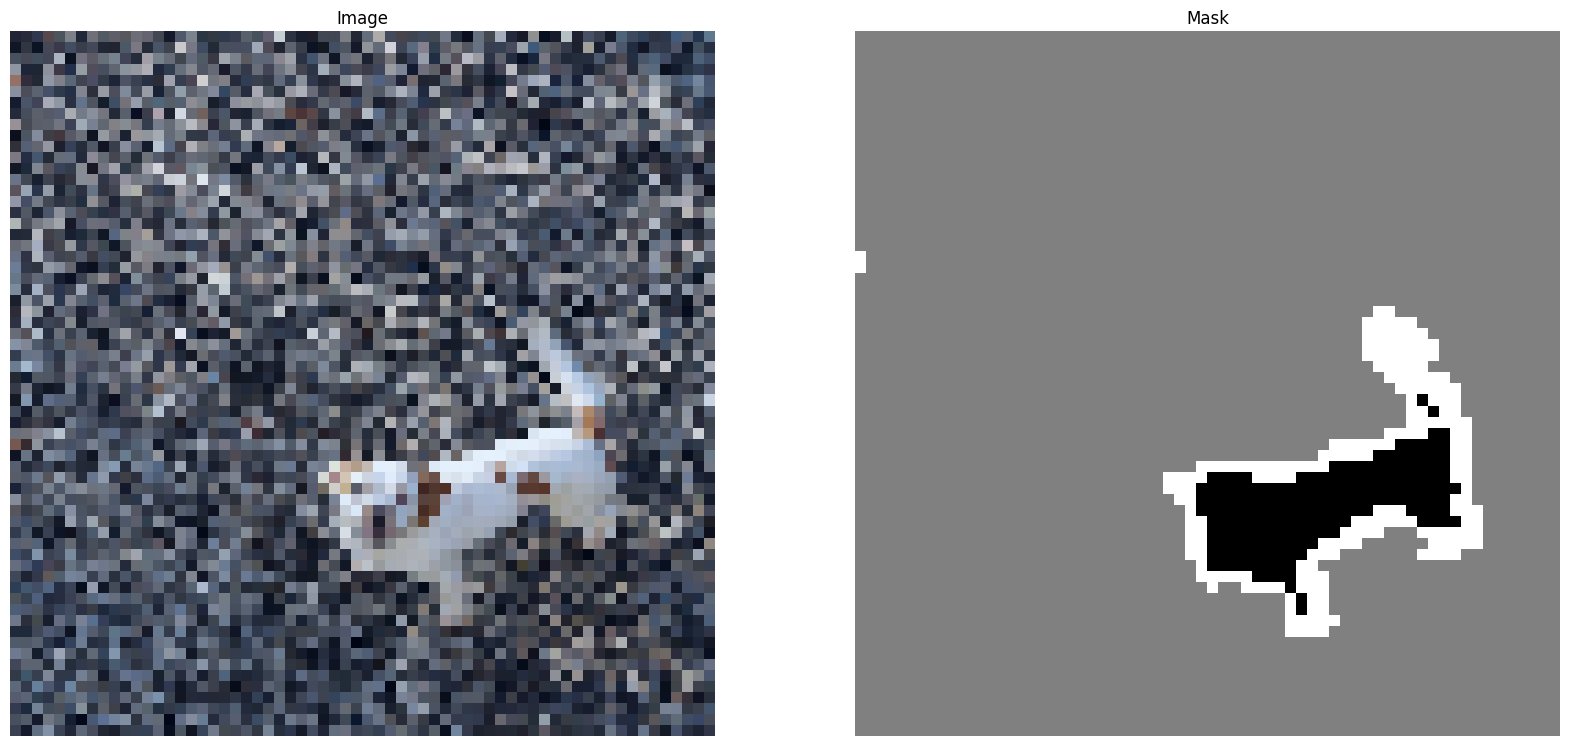

In [60]:
# visualize some images
for _ in range(3):
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    img, mask = train_set[randint(0, len(train_set))]

    # img: [3, H, W] → [H, W, 3]
    img = img.permute(1, 2, 0).cpu().numpy()

    img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Mask")
    axs[1].axis("off")
    axs[1].imshow(mask)
    


    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****



## Part 2: Implementing the network (8 Pts)

### Model Definition 
#### (Inverted Residual: 3 Pts, UNet-Decoder: 5 Pts)

We use a pretrained MobileNetV2 as our encoder and then implement our own decoder. We return three different layers for the skip connections of our "U-Net". You will implement the U-Net-Decoder and then train it on the dataset. An example overview of a complete U-Net architecture is presented here:

<center><img src="imgs/unet.png" alt="Plot" width="960" /></center>

However, our U-Net will be simpler, to reduce training time, and will only have 3 down- and upsampling steps and therefore, only two skip connections (the last upsampling is done via bilinear interpolation, to futher speed up training). For the implementation you will need these torch.nn functions:

- nn.Conv2d          (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- nn.BatchNorm2d     (https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- nn.ReLU6           (https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html)
- nn.ConvTranspose2d (https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)

ReLU6 is a modification of the `rectified linear unit` where we limit the activation to a maximum size of 6.

The final architecture should look similar to this:

- `nn.ConvTranspose2d`(kernel_size=(4,4), stride=2, padding=1, bias=True)
- `InvertedResidual`(stride=1, expand_ratio=6)
- `nn.ConvTranspose2d`(kernel_size=(4,4), stride=2, padding=1, bias=True)
- `InvertedResidual`(stride=1, expand_ratio=6)
- `nn.Conv2d`(kernel_size=(1,1))
- `nn.Conv2d`(kernel_size=(1,1))
- `torch.sigmoid`

where InvertedResidual is composed of:

- `nn.Conv2d`(kernel_size=(1,1), stride=1, padding=0, bias=False)
- `nn.BatchNorm2d`
- `nn.ReLU6`
- `nn.Conv2d`(kernel_size=(3,3), stride=stride, padding=1, bias=False)
- `nn.BatchNorm2d`
- `nn.ReLU6`
- `nn.Conv2d`(kernel_size=(1,1), stride=1, padding=0, bias=False)
- `nn.BatchNorm2d`

The dimensions of the layers can be seen here:

| Layer (type)               | Output Shape (B, C, H, W) |
|----------------------------|---------------------------|
| ├─MobileNetV2_Encoder: 1-1 | [64, 32, 8, 8]
| ├─UNet_Decoder: 1-2        | [64, 3, 32, 32]           |
| │  └─ConvTranspose2d: 2-2  | [64, 24, 8, 8]            |
| │  └─InvertedResidual: 2-3 | [64, 24, 8, 8]            |
| │  └─ConvTranspose2d: 2-4  | [64, 16, 16, 16]          |
| │  └─InvertedResidual: 2-5 | [64, 16, 16, 16]          |
| │  └─Conv2d: 2-6           | [64, 16, 32, 32]          |
| │  └─Conv2d: 2-7           | [64, 3, 32, 32]           |

where B is the batchsize, C is the number of channels, and H and W are the height and width, respectively. The hidden dimensions within the InvertedResidual layer are defined by `hidden_dim = round(inp * expand_ratio)`. 

In [ ]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()

        hidden_dim = round(inp * expand_ratio)

        # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
        self.conv = nn.Sequential(
                    # pw (pointwise)
                    nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    nn.ReLU6(inplace=True),
                    # dw (depthwise)
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    nn.ReLU6(inplace=True),
                    # pw-linear (project)
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(oup),
                )

        # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

    def forward(self, x):

        return self.conv(x)

class MobileNetV2_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = models.mobilenet_v2(weights="MobileNet_V2_Weights.IMAGENET1K_V1")

        for param in self.mobilenet.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        for n in range(0, 2):
            x = self.mobilenet.features[n](x)
        x1 = x

        for n in range(2, 4):
            x = self.mobilenet.features[n](x)
        x2 = x

        for n in range(4, 7):
            x = self.mobilenet.features[n](x)
        x3 = x

        return x1, x2, x3

# UNet Decoder
class UNet_Decoder(torch.nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()

        # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
        # dconv1: Recibe x3 (32 canales) -> Salida 24 canales (para igualar x2)
        self.dconv1 = nn.ConvTranspose2d(32, 24, kernel_size=4, stride=2, padding=1, bias=True)
        # invres1: Recibe concat(x2, dconv1) -> 24 + 24 = 48 canales. Salida 24.
        self.invres1 = InvertedResidual(48, 24, stride=1, expand_ratio=6)

        # dconv2: Recibe invres1 (24 canales) -> Salida 16 canales (para igualar x1)
        self.dconv2 = nn.ConvTranspose2d(24, 16, kernel_size=4, stride=2, padding=1, bias=True)
        # invres2: Recibe concat(x1, dconv2) -> 16 + 16 = 32 canales. Salida 16.
        self.invres2 = InvertedResidual(32, 16, stride=1, expand_ratio=6)

        # Capas finales de convolución 1x1
        # conv_last: Procesa el upsampling bilineal (mantiene 16 canales)
        self.conv_last = nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0)
        # conv_score: Reduce a los canales de salida deseados (n_classes o 3 según la tabla)
        self.conv_score = nn.Conv2d(16, n_classes, kernel_size=1, stride=1, padding=0)

        self.sigmoid = nn.Sigmoid()
        # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

    def forward(self, x):
        x1, x2, x3 = x
        # HINT:
        # print(x1.shape, x2.shape, x3.shape)
        # torch.Size([B, 16, 32, 32]) torch.Size([B, 24, 16, 16]) torch.Size([B, 32, 8, 8])
        # x2.shape == self.dconv1(x3)
        up3 = torch.cat([
            x2,
            self.dconv1(x3)
        ], dim=1)
        up3 = self.invres1(up3)

        # x1.shape == self.dconv2(up3)
        up4 = torch.cat([
            x1,
            self.dconv2(up3)
        ], dim=1)
        up4 = self.invres2(up4)

        up5 = torch.nn.functional.interpolate(up4, scale_factor=2, mode='bilinear', align_corners=False)

        x = self.conv_last(up5)

        x = self.conv_score(x)


        x = self.sigmoid(x)

        return x


### Training Loop

You shouldn't need to change anything here, except for maybe the number of epochs. An example output plot is shown here:

<center><img src="imgs/loss_and_accuracy.png" alt="Plot" width="960" /></center>

The network was trained for 50 epochs. However, this might take a while to train depending on your hardware. Though, as you can see, after 10 epochs we are already at around 75% accuracy. Which should be sufficient for early experiments, so you can quickly see wether you approach works.

cpu

Epoch 0:


100%|██████████| 11/11 [02:15<00:00, 12.36s/it]


Validation:


100%|██████████| 4/4 [00:40<00:00, 10.16s/it]


-> Epoch: 0.0. Validation.  Accuracy: 0.556

Epoch 1:


100%|██████████| 11/11 [02:34<00:00, 14.09s/it]


Validation:


100%|██████████| 4/4 [00:41<00:00, 10.38s/it]


-> Epoch: 1.0. Validation.  Accuracy: 0.763

Epoch 2:


100%|██████████| 11/11 [02:21<00:00, 12.82s/it]


Validation:


100%|██████████| 4/4 [00:34<00:00,  8.63s/it]


-> Epoch: 2.0. Validation.  Accuracy: 0.775

Epoch 3:


100%|██████████| 11/11 [02:27<00:00, 13.44s/it]


Validation:


100%|██████████| 4/4 [00:35<00:00,  8.81s/it]


-> Epoch: 3.0. Validation.  Accuracy: 0.791

Epoch 4:


100%|██████████| 11/11 [02:23<00:00, 13.08s/it]


Validation:


100%|██████████| 4/4 [00:36<00:00,  9.15s/it]


-> Epoch: 4.0. Validation.  Accuracy: 0.799

Epoch 5:


100%|██████████| 11/11 [01:44<00:00,  9.52s/it]


Validation:


100%|██████████| 4/4 [00:33<00:00,  8.26s/it]


-> Epoch: 5.0. Validation.  Accuracy: 0.803

Epoch 6:


100%|██████████| 11/11 [2:31:57<00:00, 828.87s/it]  


Validation:


100%|██████████| 4/4 [00:22<00:00,  5.54s/it]


-> Epoch: 6.0. Validation.  Accuracy: 0.818

Epoch 7:


100%|██████████| 11/11 [01:41<00:00,  9.26s/it]


Validation:


100%|██████████| 4/4 [00:19<00:00,  4.97s/it]


-> Epoch: 7.0. Validation.  Accuracy: 0.822

Epoch 8:


100%|██████████| 11/11 [01:26<00:00,  7.88s/it]


Validation:


100%|██████████| 4/4 [00:26<00:00,  6.55s/it]


-> Epoch: 8.0. Validation.  Accuracy: 0.829

Epoch 9:


100%|██████████| 11/11 [02:20<00:00, 12.76s/it]


Validation:


100%|██████████| 4/4 [00:34<00:00,  8.56s/it]


-> Epoch: 9.0. Validation.  Accuracy: 0.832

Epoch 10:


100%|██████████| 11/11 [02:01<00:00, 11.03s/it]


Validation:


100%|██████████| 4/4 [00:35<00:00,  9.00s/it]


-> Epoch: 10.0. Validation.  Accuracy: 0.834


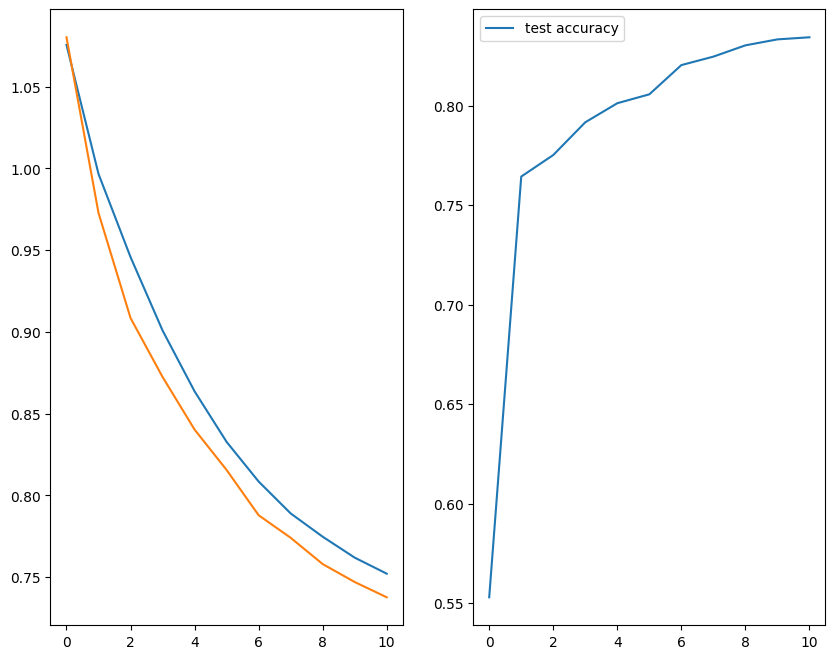

In [56]:
# Training
def train(model, loader, optimizer, loss_fn, device, epoch):
    model.train()
    train_loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

def validate(model, loader, loss_fn, device, epoch):
    model.eval()
    test_loss = 0
    avg_acc = 0
    print("Validation:")
    with torch.no_grad():
        for x, y in tqdm(loader):
            x, y = x.to(device), y.to(device)
            pred = model(x).squeeze(1)
            loss = loss_fn(pred, y)
            test_loss += loss.item()

            _, pred = torch.max(pred, 1)
            correct = torch.mean((pred == y).type(torch.float64))
            avg_acc += correct.cpu()
    print("-> Epoch: {:.1f}. Validation.  Accuracy: {:.3f}".format(epoch, avg_acc / len(loader)))
    return test_loss / len(loader), correct.cpu().numpy()

def train_loop(model, train_loader, validation_loader, loss_fn, optimizer, device, epochs=10):
    train_losses, test_losses, test_accuracy = [], [], []
    for epoch in range(epochs):
        print(f"\nEpoch {epoch}:")
        train_loss = train(model, train_loader, optimizer, loss_fn, device, epoch)
        test_loss, accuracy = validate(model, validation_loader, loss_fn, device, epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracy.append(accuracy)
    return train_losses, test_losses, test_accuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = MobileNetV2_Encoder().to(device)
decoder = UNet_Decoder(n_classes=3).to(device)
model = torch.nn.Sequential(encoder, decoder).to(device)
model.to(device)

# from torchinfo import summary
# print(summary(encoder.mobilenet, input_size=(64, 3, 32, 32)))
# print(summary(model, input_size=(64, 3, 32, 32)))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, test_accuracy = train_loop(model, train_loader, validation_loader, criterion, optimizer, device, epochs=11)

plt.subplot(1,2,1)
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.subplot(1,2,2)
plt.plot(test_accuracy, label="test accuracy")
plt.legend()
plt.show()

## Part 3: Evaluation (3 Pts)

In order to gain a deeper understanding of our network's performance, we will be analyzing a selection of its predictions through both qualitative and quantitative methods. Let's begin by focusing on the qualitative analysis, where we'll take a closer look at some visualizations of the predictions.

For context, qualitative analysis involves evaluating the subjective aspects of data, such as visual appearance, whereas quantitative analysis involves examining objective data, such as numerical measurements or statistical analysis. By combining both approaches, we can gain a more comprehensive understanding of our model's strengths and limitations.

### Qualitative Analysis (1 Pt)

The network should predict masks similiar in quality to this (However, some images are harder to predict and thus result in worse masks):

<center><img src="imgs/network_output.png" alt="Plot" width="960" /></center>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9873199722766877].


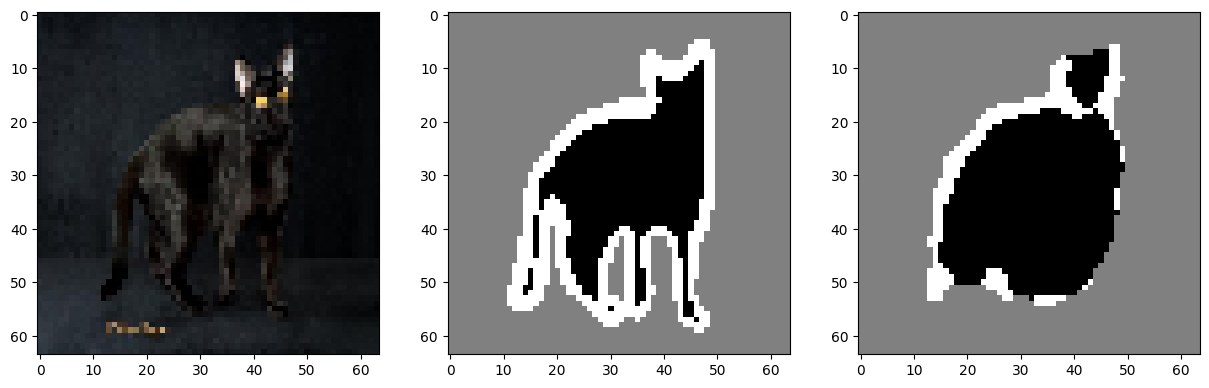

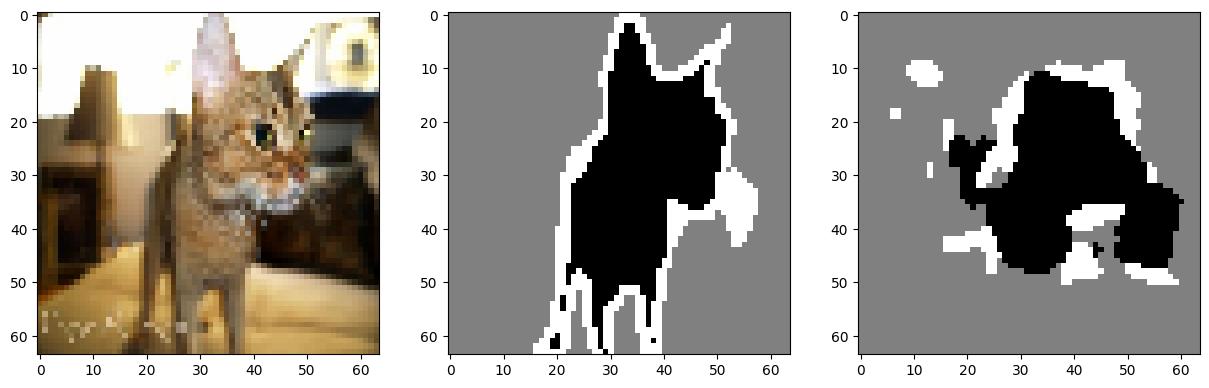

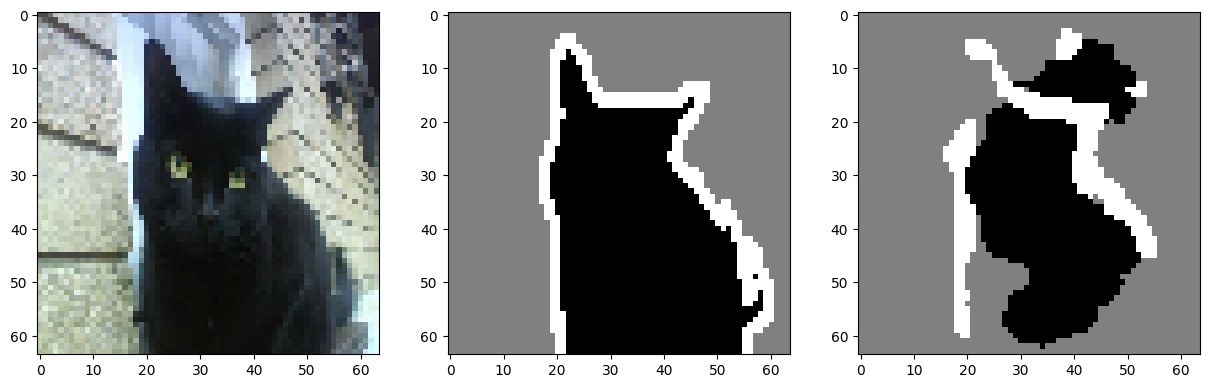

In [57]:
# Visualize some predictions
model.eval()
with torch.no_grad():
    for x, y in validation_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        _, pred = torch.max(pred, 1)
        break

for i in range(3):
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(imagenet_denorm(x[i].permute(1, 2, 0).cpu().numpy()))
    plt.subplot(1,3,2)
    plt.imshow(y[i].cpu().numpy(), cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(pred[i].cpu().numpy(), cmap='gray')
    plt.show() 
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

### Quantitative Analysis (2 Pts)

In order to ensure the accuracy of our model on the test set, we will be implementing the Intersection over Union (IoU) metric. It's worth noting that in a real-world scenario, we would typically use a separate test set for this purpose. However, for the purposes of this exercise, we will be utilizing the validation set. A reasonable IoU to achive for this exercise is `0.45`, however, depending on the training time it may also be lower. In this case increasing the epochs might increase the IoU, especially, if the loss of the validation data is still decreasing.

In [63]:
def iou(pred, target):
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****

    return np.nanmean([(pred & target).sum() / (pred | target).sum() for pred, target in zip(pred, target)])
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

In [64]:
model.eval()

with torch.no_grad():
    iou_list = []
    for inputs, targets in validation_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        preds = torch.argmax(outputs, dim=1)  # get predicted segmentation map

        iou_val = iou(preds, targets)  # compute IoU
        iou_list.append(iou_val)

mean_iou = sum(iou_list) / len(iou_list)
print('Mean IoU:', mean_iou)

Mean IoU: 0.6507752
